In [1]:
import os
import pandas as pd
from PDB_download import get_AFmodel, get_pdbModel
import matplotlib.pyplot as plt
import numpy as np
from Bio import PDB
from Bio.PDB.Polypeptide import protein_letters_3to1

,hugo_name,uniprot_id,structure_id,coverage,experimental_method,resolution,r_free,complex_protein,complex_nucleotide,complex_ligand,complex_ligand_details,mutations_in_pdb
9,PXD013001,Q99627,6R7F,"{'H': '[(11, 165);(197, 209)]'}",ELECTRON MICROSCOPY,8.2,NA,protein complex,NA,NA,NA,NA
11,PXD013001,Q99627,6R7H,"{'H': '[(11, 165);(196, 209)]'}",ELECTRON MICROSCOPY,8.8,NA,protein complex,NA,NA,NA,NA
0,PXD013001,Q99627,AF-Q99627-F1-model_v4,"{'A': '[(12, 167);(192, 209)]'}",PREDICTED,NaN,NA,NA,NA,NA,NA,NA


Q99627
sequence length: 209


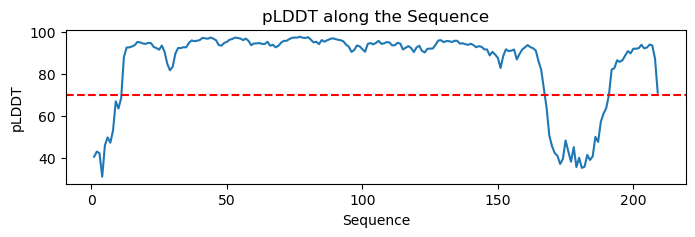

Low Confidence Ranges:
[(0, 10), (167, 189)]


In [7]:
from pandas.plotting import table
from IPython.display import display, HTML

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/PDBminer/results'
folder_list = os.listdir(root_dir)
AF_model_list = []
uni_id = 'Q99627'
subset = ['hugo_name', 'uniprot_id', 'structure_id', 'coverage', 'experimental_method', 'resolution', 'r_free', \
          'complex_protein', 'complex_nucleotide', 'complex_ligand', \
          'complex_ligand_details', 'mutations_in_pdb']

for folder in folder_list:
    if not folder == uni_id:
        continue

    filename = f'{folder}_all.json'
    filepath = os.path.join(root_dir, folder, filename)

    if os.path.isfile(filepath):
        df = pd.read_json(filepath)

        df['resolution'] = pd.to_numeric(df['resolution'], errors='coerce')        
        #df = df[(df['resolution'].astype(float)<3.0) & (df['experimental_method']=='X-RAY DIFFRACTION')]

        #df = df[(df['mutations_in_pdb']=='NA') & (df['complex_nucleotide']=='NA') & (df['complex_protein']=='NA')]
        df = df[(df['mutations_in_pdb']=='NA') & (df['complex_ligand']=='NA')]
        #df = df[(df['mutations_in_pdb']=='NA')]

        df = df[subset]

        df = df.sort_values(by=['resolution'])
        display(HTML(df.to_html()))   
    break

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/structure/'
filename = f'AF-{uni_id}-F1-model_v4.pdb'
filepath = os.path.join(root_dir, folder, filename)

def parse_pdb(filepath):
    parser = PDB.PDBParser()
    structure = parser.get_structure('AF_structure', filepath)
    sequence = []
    plddt_scores = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    plddt_scores.append(residue['CA'].get_bfactor())  # Assuming pLDDT in B-factor column
    return plddt_scores

# Check if the file exists and parse it
if os.path.isfile(filepath):
    plddt_scores = parse_pdb(filepath)
    print(uni_id)
    print('sequence length:', len(plddt_scores))

    # Plot pLDDT along the sequence
    plt.figure(figsize=(8, 2))
    plt.plot(range(1,len(plddt_scores)+1), plddt_scores)
    plt.xlabel('Sequence')
    plt.ylabel('pLDDT')
    plt.title('pLDDT along the Sequence')
    plt.axhline(y=70, color='red', linestyle='--')
    plt.show()

    plddt_scores = np.array(plddt_scores)
    low_confidence = np.where(plddt_scores < 70)[0]
    low_confidence_ranges = []
    if len(low_confidence) > 0:
        start = low_confidence[0]
        end = low_confidence[0]
        for i in range(1, len(low_confidence)):
            if low_confidence[i] == end + 1:
                end = low_confidence[i]
            else:
                low_confidence_ranges.append((start, end))
                start = low_confidence[i]
                end = low_confidence[i]
        low_confidence_ranges.append((start, end))

        print('Low Confidence Ranges:')
        print(low_confidence_ranges)
    else:
        print('No low confidence regions found.')

else:
    print("File not found.")

In [ ]:
### output low confidence regions to excel file  ###

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection'
apo_df = pd.read_excel(f'{root_dir}/merged_apo.xlsx', sheet_name='Sheet1')

for index, row in apo_df.iterrows():
    folder = row['database_id'].strip()
    uni_id = row['match_uni'].strip()
    print(index, folder, uni_id)

    AF_dir = f'{root_dir}/feature/structure/'
    filename = f'AF-{uni_id}-F1-model_v4.pdb'
    filepath = os.path.join(AF_dir, uni_id, filename)
    
    plddt_scores = parse_pdb(filepath)
    
    plddt_scores = np.array(plddt_scores)
    low_confidence = np.where(plddt_scores < 70)[0]
    low_confidence_ranges = []
    if len(low_confidence) > 0:
        start = low_confidence[0]
        end = low_confidence[0]
        for i in range(1, len(low_confidence)):
            if low_confidence[i] == end + 1:
                end = low_confidence[i]
            else:
                low_confidence_ranges.append((start, end))
                start = low_confidence[i]
                end = low_confidence[i]
        low_confidence_ranges.append((start, end))
    
    apo_df.loc[index, 'low_confidence_ranges'] = str(low_confidence_ranges)

apo_df.to_excel(f'{root_dir}/merged_apo_modified.xlsx', sheet_name='Sheet1', index=False)

In [ ]:
### mutation modelling ###

from predataprocess import get_pdb_seq, mut_seq, mutseq_align, single_model
from Bio import PDB
import shutil

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection'
apo_df = pd.read_excel(f'{root_dir}/merged_apo.xlsx', sheet_name='Sheet1')

apo_df = apo_df.dropna(subset=['mutation'])
print(apo_df.shape)
AF_dir = f'{root_dir}/feature/structure/'

for index, row in apo_df.iterrows():
    folder = row['database_id'].strip()
    uni_id = row['match_uni'].strip()
    mutation = row['mutation'].strip().split('/')
    filepath = os.path.join(AF_dir, uni_id, f'AF-{uni_id}-F1-model_v4_Hplus.pdb')
    print(index, folder, uni_id, mutation)
    
    mutate_id = int(mutation[0][1:-1])-1
    if os.path.isfile(filepath):
        parser = PDB.PDBParser()
        structure = parser.get_structure('AF_structure', filepath)
        sequence, residue_indices = get_pdb_seq(structure)

        mutated_sequence = mut_seq(residue_indices, mutation)
        if mutated_sequence:
            print(sequence[mutate_id], '->', mutated_sequence[mutate_id])
            pass
        else:
            mutated_sequence = 'M'+sequence 

        PDB_seq = [sequence, mutated_sequence]
        info = [uni_id, mutation[0],'','','A','A']
        mutseq_align(PDB_seq, 0, directory=f'{root_dir}/feature/alignment',info=info)

        #shutil.copyfile(filepath, f'{root_dir}/feature/structure/{uni_id}/{uni_id}.pdb')
        shutil.copyfile(f'{root_dir}/feature/alignment/alignment_{uni_id}_{mutation[0]}.ali', f'{root_dir}/feature/structure/{uni_id}/alignment_{uni_id}_{mutation[0]}.ali')
        single_model(uni_id, mutation[0], dst_dir=f'{root_dir}/feature/structure/{uni_id}')


In [20]:
root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection'

apo_df = pd.read_excel(f'{root_dir}/merged_apo.xlsx', sheet_name='Sheet1')
#apo_df = apo_df.loc[(apo_df['modification'] != 'monomer') & (apo_df['modification'] != 'nk')]
print(apo_df.shape)

#display(apo_df.loc[:, ['database_id', 'protein', 'state', 'match_uni', 'modification', 'mutation', 'truncation']])

for index, row in apo_df.iterrows():
    folder = row['database_id'].strip()
    uni_id = row['match_uni'].strip()
    mutation = row['mutation']
    modification = row['modification'].strip()

    if mutation == '' or pd.isna(mutation):
        print(index, folder, uni_id, mutation)
        if modification == 'monomer' or modification == 'nk':
            apo_identifier = f'AF-{uni_id}-F1-model_v4_Hplus.pdb'
            apo_df.loc[index, 'apo_identifier'] = apo_identifier
        else:
            pass
    else:
        if modification == 'monomer' or modification == 'nk':
            apo_identifier = f'{uni_id}_{mutation}.B99990001.pdb'
            apo_df.loc[index, 'apo_identifier'] = apo_identifier
        else:
            pass
    
apo_df.to_excel(f'{root_dir}/merged_apo_modified.xlsx', sheet_name='Sheet1', index=False)


(77, 18)
0 JACS_ADA P03958 nan
1 MSV000086658 P29317 nan
2 MSV000088425 P00734 nan
3 MSV000088648 Q9UKV8 nan
4 MSV000090611 P00749 nan
5 MSV000090815 P08571 nan
7 PXD010586 P62491 nan
8 PXD010586 O60239 nan
9 PXD010586 O60239 nan
10 PXD011914 B5BTR7 nan
11 PXD013001 P61201 nan
12 PXD013001 Q9BT78 nan
13 PXD013001 Q13098 nan
14 PXD013001 Q13617 nan
15 PXD013001 P40337 nan
16 PXD013001 Q15370 nan
17 PXD013001 Q13098 nan
18 PXD013001 P61201 nan
19 PXD013001 Q9UNS2 nan
20 PXD013001 Q9BT78 nan
22 PXD013001 Q7L5N1 nan
23 PXD013001 Q9H9Q2 nan
24 PXD013001 Q99627 nan
25 PXD013001 Q13617 nan
26 PXD013001 Q15370 nan
27 PXD013001 Q15369 nan
28 PXD013001 P62877 nan
29 PXD013001 P40337 nan
30 PXD013051 Q9P2K8 nan
31 PXD013841 Q7K4Y6 nan
32 PXD015778 Q96B36 nan
33 PXD015778 Q8N122 nan
36 PXD017095 Q93034 nan
37 PXD017095 Q9UBF6 nan
38 PXD017156 O95376 nan
40 PXD018028 Q1D489 nan
41 PXD019047 P31224 nan
42 PXD019199 P80075 nan
44 PXD019367 P62873 nan
45 PXD019367 P59768 nan
46 PXD019367 P09471 nan
47

In [35]:
from predataprocess import get_pdb_seq

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/structure/Q9Y5R8/AF_TRAPP_1+3+4+6a_revised.pdb'

parser = PDB.PDBParser()
structure = parser.get_structure('AF_structure', root_dir)
sequence, residue_indices = get_pdb_seq(structure, 'B')
print(sequence)

KMSSELFTLTYGALVTQLCKDYENDEDVNKQLDKMGFNIGVRLIEDFLARSNVGRCHDFRETADVIAKVAFKMYLGITPSITNWSPAGDEFSLILENNPLVDFVELPDNHSSLIYSNLLCGVLRGALEMVQMAVEAKFVQDTLKGDGVTEIRMRFIRRIED


/Users/liyao/miniconda3/envs/liyao_env/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5420
  warnings.warn(


In [1]:
### revise the Hdock model pdb file ###
import os

pdb_dir = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/hdock_files'
folder = '8F7A'

pdb_fpath = os.path.join(pdb_dir, folder)
pdb_file = [f'MODEL_{i}' for i in range(1, 501)]

count = 0
for pdb in pdb_file:
    with open(f'{pdb_fpath}/{pdb}.pdb', 'r') as f, open(f'{pdb_fpath}/{pdb}_REVISED.pdb', 'w') as out:
        chain_id = ord('A')  # ASCII value of 'A'
        prev_residue_index = None

        for line in f:
            if line.startswith('ATOM'):
                atom_name = line[12:16].strip()
                occupancy = "1.00"
                bfactor = "1.00"
                element = atom_name[0]

                new_line = line[:54] + f"{occupancy:>6}{bfactor:>6}" + line[66:76] + f"{element:>2}" + line[78:]

                pass
                '''current_residue_index = int(line[22:26].strip())

                if prev_residue_index is not None and current_residue_index < prev_residue_index:
                    chain_id += 1
                    # Ensure that the chain ID doesn't exceed 'Z'
                    if chain_id > ord('Z'):
                        chain_id = ord('A')

                # Replace the chain ID
                line = line[:21] + chr(chain_id) + line[22:]
                prev_residue_index = current_residue_index'''
            elif line.startswith('HEADER rec.pdb'):
                line = line.replace('rec.pdb', f'{pdb}.pdb')
            elif line.startswith('HEADER lig'):
                continue
            out.write(line)
        
        count += 1

print(count)

500


In [5]:
### revise the Hdock model pdb file ###
import os 

pdb_fpath = '/home/lwang/AI-HDX-main/HDX_MS_dataset/complexpair_dataset/structure'
#pdb_file = os.listdir(pdb_fpath)
pdb_file = ['3sn6.pdb', '6oik.pdb']
for pdb in pdb_file:
    pdb = pdb.split('.')[0]
    print(pdb)

    with open(f'{pdb_fpath}/{pdb}.pdb', 'r') as f, open(f'{pdb_fpath}/{pdb}_revised.pdb', 'w') as out:
        chain_id = ord('A')  # ASCII value of 'A'
        prev_residue_index = None

        for line in f:
            if line.startswith('ATOM'):
                current_residue_index = int(line[22:26].strip())

                if prev_residue_index is not None and current_residue_index < prev_residue_index:
                    chain_id += 1
                    # Ensure that the chain ID doesn't exceed 'Z'
                    if chain_id > ord('Z'):
                        chain_id = ord('A')

                # Replace the chain ID
                line = line[:21] + chr(chain_id) + line[22:]
                prev_residue_index = current_residue_index
            elif line.startswith('HEADER rec.pdb'):
                line = line.replace('rec.pdb', f'{pdb}.pdb')
            elif line.startswith('HEADER lig'):
                continue
            elif line.startswith('ANISOU'):
                continue
            out.write(line)


3sn6
6oik
